In [ ]:
import bottleneck as bn
import matplotlib
import matplotlib.dates as mdates
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scienceplots
import scipy
import scipy.signal
import scipy.special
import scipy.stats
import sklearn.decomposition
import astropy.io
import datetime
import astropy.time
import pandas as pd

import scipy.ndimage
import ssqueezepy
import numpy as np


from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.style.use(['science', 'nature', 'notebook', 'grid', 'high-vis'])

figsize_short = (8, 4)
figsize_normal = (8, 6)
figsize_tall = (8, 8)
plt.rcParams['figure.figsize'] = figsize_short
plt.rcParams['axes.labelpad'] = 6.0
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.framealpha'] = 0.8
plt.rcParams['legend.edgecolor'] = 'none'


title_font = {'fontsize': 16, 'weight': 'bold', 'style': 'italic'}
path_effect = [pe.withStroke(linewidth=2.0, foreground="k")]

read_path = 'docs/Data/'
save_path = 'docs/Figure/'

perula_df = pd.read_csv(read_path + 'matlab_perula.txt', header = None, sep = '\s+')
matlab_perula = matplotlib.colors.LinearSegmentedColormap.from_list('matlab_perula', np.array(perula_df))

jet_df = pd.read_csv(read_path + 'matlab_jet.txt', header = None, sep = '\s+')
matlab_jet = matplotlib.colors.LinearSegmentedColormap.from_list('matlab_jet', np.array(jet_df))

%matplotlib ipympl

<>:41: SyntaxWarning: invalid escape sequence '\s'
<>:44: SyntaxWarning: invalid escape sequence '\s'
<>:41: SyntaxWarning: invalid escape sequence '\s'
<>:44: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Administrator\AppData\Local\Temp\ipykernel_31060\3118345031.py:41: SyntaxWarning: invalid escape sequence '\s'
  perula_df = pd.read_csv(read_path + 'matlab_perula.txt', header = None, sep = '\s+')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_31060\3118345031.py:44: SyntaxWarning: invalid escape sequence '\s'
  jet_df = pd.read_csv(read_path + 'matlab_jet.txt', header = None, sep = '\s+')


In [ ]:
def fractional_boxcar_kernel(w: float, nv: int = 16) -> np.ndarray:
    """
    Build a *fractional* (non-integer) boxcar kernel suitable for smoothing
    wavelet spectra along the scale axis.

    The routine is mathematically equivalent to convolving the data with a
    continuous rectangular window of width ``w`` *octaves*, then sampling the
    result on a discrete grid that has ``nv`` voices (scales) per octave.  
    If that width does not fall on an integer number of voices, the two edge
    weights are reduced proportionally so that the discrete kernel integrates
    to exactly one.

    Parameters
    ----------
    w : float
        Desired window width expressed **in octaves** (e.g., ``0.6`` gives
        ±0.3 octave around each scale).
    nv : int, optional
        Number of voices (wavelet scales) per octave.  Higher values give a
        finer scale grid; values ≥ 16 are typical.  Must be positive.

    Returns
    -------
    kernel : numpy.ndarray
        One-dimensional, symmetric array of length ``L``, where ``L`` is the
        smallest odd integer ≥ ``w * nv``.  The values sum to unity, so the
        kernel can be used directly in `numpy.convolve`, `scipy.signal.convolve`,
        or `scipy.ndimage.uniform_filter`-style operations.

    Examples
    --------
    >>> k = fractional_boxcar_kernel(0.6, nv=12)
    >>> k
    array([0.01388889, 0.13888889, 0.13888889, 0.13888889, 0.13888889,
           0.13888889, 0.13888889, 0.13888889, 0.01388889])
    >>> k.sum()
    1.0
    """
    if w <= 0:
        raise ValueError("`w` must be positive.")
    if nv <= 0:
        raise ValueError("`nv` must be a positive integer.")

    # Continuous width expressed on the discrete voice grid
    w_voice = w * nv                       # e.g. 0.6 oct × 12 voices/oct = 7.2 voices

    # Fractional part to be split between the two edges
    residual = ((w_voice - 1) % 2) / 2.0   # 0 ≤ residual < 1

    # Ensure an odd kernel length so the window is centred
    length = int(2 * ((w_voice + 1) // 2) + 1)

    # Ones in the middle, fractional weights at the ends
    kernel = np.ones(length, dtype=float)
    kernel[0] = kernel[-1] = residual

    # Normalise to unit area
    kernel /= w_voice
    return kernel

def estimate_ar1(sig):
    _sig = np.copy(sig)
    _sig -= np.mean(sig)
    _sig /= np.std(_sig)
    cov0 = (_sig * _sig).mean()
    cov1 = (_sig[:-1] * _sig[1:]).mean()
    ar1 = cov1 / cov0
    # g = np.sqrt((1 - ar1 ** 2) * cov0)
    return ar1

def smooth_spec_gaussian(spec, scales):
    _spec = np.copy(spec)
    for i, s in enumerate(scales):
        _spec[i] = scipy.ndimage.gaussian_filter1d(spec[i], sigma=s, axis = 0, mode = 'constant', cval = 0.0)
    return _spec

def zero_padding(sig, N = None):
    if N is None:
        N = 2 ** np.ceil(np.log2(len(sig)) + 1)
    if len(sig) < N:
        return np.pad(sig, (0, int(N - len(sig))), mode='constant', constant_values=0)
    else:
        return sig

def ar1_significance_level(scale, ar1 = 0, percentile = 0.95):
    return (1 - ar1 ** 2) / (1 + ar1 ** 2 - 2 * ar1 * np.cos(2 * np.pi * scale))[:] * scipy.stats.chi2(2).ppf(percentile) / 2


import ssqueezepy
"""
Rule of thumb for the shape of numpy.ndarray: Frequency Dimension (Nf) -> Time Dimension (Nt) -> Different Wavelets (Ns, if exist) -> Component/Channel Dimension (3, or 3 x 3 / 6 x 3 for spectral maxtrix)
"""

import numpy as np

def fractional_boxcar_kernel(w: float) -> np.ndarray:
    if w <= 0:
        raise ValueError("`w` must be positive.")
    

    # Fractional part to be split between the two edges
    residual = ((w - 1) % 2) / 2.0   # 0 ≤ residual < 1

    # Ensure an odd kernel length so the window is centred
    length = int(2 * ((w + 1) // 2) + 1)

    # Ones in the middle, fractional weights at the ends
    kernel = np.ones(length, dtype=float)
    kernel[0] = kernel[-1] = residual

    # Normalise to unit area
    kernel /= w
    return kernel

def smooth_spec_gaussian(spec, scales, a = 1, axis = 0):
    _spec = np.copy(spec)
    for i, s in enumerate(scales):
        _spec[i] = scipy.ndimage.gaussian_filter1d(spec[i], sigma = s * a, axis = axis, mode = 'constant', cval = 0.0)

    return _spec

def smooth_spec_box(spec: np.ndarray, scales: np.ndarray, w: float, axis = 0):    
    dj = np.abs(np.diff(np.log2(scales))[0])
    print(dj)
    w = w / dj
    _kernel = fractional_boxcar_kernel(w)
    kshape = [1] * spec.ndim
    kshape[axis] = _kernel.size
    _kernel = _kernel.reshape(kshape)
    _spec = scipy.signal.convolve(spec * scales[:, np.newaxis, np.newaxis, np.newaxis], _kernel, mode = 'same')
    return _spec

def wavelet_coef_psd(time: np.ndarray, signal: np.ndarray, scales: np.ndarray, bandwidth: float = 6.0, downsample: int = 1, downsample_signal: bool = True):
    """
    Compute complex Morlet wavelet coefficients and power spectral density (PSD).
    Complex Morlet wavelet can be written as:

    Parameters:
    ----------
    time : np.ndarray
        Time vector of shape (Nt,). Can be in seconds or `np.datetime64`.
    signal : np.ndarray
        Input signal of shape (Nt,).
    scales : np.ndarray
        Wavelet scales corresponding to frequencies of shape (Nf,).
    bandwidth : float, optional
        bandwidthandwidth parameter for the Morlet wavelet (default is 6.0).
    downsample : int, optional
        Downsampling factor for the output (default is 1, meaning no downsampling).
    downsample_signal : bool, optional
        If True, downsample the input signal before computing wavelet coefficients (default is False).
        If False, the signal is not downsampled, but the output coefficients and PSD are downsampled.

    Returns:
    -------
    time : np.ndarray
        Time vector after optional downsampling.
    frequency : np.ndarray
        Frequencies corresponding to the wavelet scales.
    coef : np.ndarray
        Complex wavelet coefficients of shape (Nf, Nt), where Nf is the number of frequencies.
    psd : np.ndarray
        Power spectral density of shape (Nf, Nt).
    signal : np.ndarray
        Downsampled (moving average) signal if downsampling is applied.

    Notes:
    -----
    - The function uses `scipy.signal.cwt` with the Morlet wavelet by default.
    - `scipy.signal.cwt` is deprecated in SciPy 1.12 and will be removed in SciPy 1.15. Alternatives like PyWavelets or ssqueezepy can be used.
    - The power spectral density (PSD) is computed as the squared magnitude of the wavelet coefficients, scaled by `2 * dt`.
    - Downsampling is applied to the time, coefficients, PSD, and signal if `downsample > 1`.
    """

    if downsample_signal:
        time = time[::downsample]
        signal = signal[::downsample]
        downsample = 1

    if isinstance(time[0], np.datetime64):
        elapsed_time = np.array(time).astype('datetime64[ns]').astype('float') / 1e9
    else:
        elapsed_time = np.array(time)

    dt = elapsed_time[1] - elapsed_time[0]

    # === Option 1: scipy.signal implementation ===
    # bandwidthut, scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed in SciPy 1.15. 
    # They recommend using PyWavelets instead.
    # https://docs.scipy.org/doc/scipy-1.12.0/reference/generated/scipy.signal.cwt.html
    # However, as you can see in the bottom code block, pywt.cwt is actually problematic for the Morlet wavelet.

    # widths = bandwidth * scales / (2 * np.pi)
    # coef = scipy.signal.cwt(
    #     signal,
    #     scipy.signal.morlet2,
    #     widths = widths,
    #     w = bandwidth,
    #     dtype = np.complex128
    # )
    # frequency = 1 / dt / scales

    # === Option 2: pywt implementation ===
    # Unlike scipy.signal.cwt, pywt.cwt is not L2-normalized.
    # You need to multiply the coefficients by a factor to make them L2-normalized.
    # Another two problems with pywt.cwt: The precision of the wavelet may be unenough while you can still not adjust the precision yourself.
    # Check https://github.com/PyWavelets/pywt/issues/531
    # This defect has been proposed at 2019 but still not fixed yet.

    # central_frequency = 1.0
    # wavelet = 'cmor%.1f-%.1f' % (bandwidth, central_frequency)
    # coef, frequency = pywt.cwt(signal, scales, wavelet, dt, method = 'fft')
    # coef *= np.sqrt(np.sqrt(bandwidth) * np.sqrt(2 * np.pi))  # amplitude normalization for Morlet

    # === Option 3: ssqueezepy implementation (default used here) ===
    # This one is accurate and fast. They claim that this package is the fastest implementation of the wavelet transform in Python.
    # bandwidthut, this implementation is not elegantly designed and the input parameters are not well documented.
    # Also, it requires package numba, which may raise some compatibility issues.
    coef, scales = ssqueezepy.cwt(signal - np.mean(signal), ('morlet', {'mu': bandwidth}), scales = bandwidth / (2 * np.pi) * scales.astype(np.float32), fs = 1 / dt, l1_norm = False, padtype = 'zero')
    frequency = bandwidth / (2 * np.pi) / dt / scales

    # coef, _, frequency, _ = ssqueezepy.ssq_cwt(signal, ('morlet', {'mu': bandwidth}), scales = bandwidth / (2 * np.pi) * scales.astype(np.float32), fs = 1 / dt)
    # coef = (coef.T * bandwidth * np.sqrt(scales / np.pi)).T

    psd = (np.abs(coef) ** 2) * (2 * dt)
    
    return time[::downsample], frequency, coef[:, ::downsample], psd[:, ::downsample], signal[::downsample]

def wfft_coef_psd(time: np.ndarray, signal: np.ndarray, step: int = 1, window: int = 120):
    """
    Compute short-time Fourier transform (STFT) coefficients and power spectral density (PSD) using a sliding Hanning window.

    Parameters:
    ----------
    time : np.ndarray
        Time vector of shape (Nt,). Can be in seconds or `np.datetime64`.
    signal : np.ndarray
        Input signal of shape (Nt,).
    step : int, optional
        Step size for sliding the window (default is 1).
    window : int, optional
        Window length in samples (default is 120).

    Returns:
    -------
    wtime : np.ndarray
        Center time for each window after sliding.
    freq : np.ndarray
        Frequency vector corresponding to the FFT.
    coef : np.ndarray
        Complex FFT coefficients of shape (Nf, Nt), where Nf is the number of frequencies.
    psd : np.ndarray
        Power spectral density of shape (Nf, Nt).
    wsignal : np.ndarray
        Window-averaged signal of shape (Nt,).

    Notes:
    -----
    - The Hanning window is applied to each segment, and normalization is performed based on Parseval's theorem.
    - The PSD is computed as the squared magnitude of the FFT coefficients, scaled by `2 * dt / window`.
    """

    if isinstance(time[0], np.datetime64):
        elapsed_time = np.array(time).astype('datetime64[ns]').astype('float') / 1e9
    else:
        elapsed_time = np.array(time)

    dt = elapsed_time[1] - elapsed_time[0]
    # Apply sliding window view
    wtime = np.lib.stride_tricks.sliding_window_view(elapsed_time, window)[::step][:, 0] + dt * window / 2
    freq = np.fft.fftfreq(window, dt)[:window // 2]
    freq = np.fft.rfftfreq(window, dt)
    freq = np.abs(freq)
    wsignal = np.lib.stride_tricks.sliding_window_view(signal, window)[::step]
    wsignal = wsignal - np.nanmean(wsignal, axis=-1, keepdims=True)  # Remove mean to avoid DC component
    # Apply Hanning window and normalize based on Parseval's theorem
    wsignal = wsignal * np.sqrt(8 / 3) * np.hanning(window + 1)[:-1]

    coef = np.fft.fft(wsignal, axis=-1)[:, :window // 2].T
    coef = np.fft.rfft(wsignal, axis=-1).T


    psd = (np.abs(coef) ** 2) * dt / window
    
    # Double the PSD values except for the DC component and Nyquist frequency
    if window % 2 == 0:
        psd[1:-1] *= 2

    else:
        psd[1:] *= 2

    if isinstance(time[0], np.datetime64):
        wtime = (np.array(wtime) * 1e9).astype('datetime64[ns]')

    wsignal = np.mean(wsignal, axis=-1)

    return wtime, freq, coef, psd, wsignal


def svd_wave_analysis(spec: np.ndarray, freq_window: int = 5, time_window: int = 5):
    """
    Perform SVD-based wave polarization analysis to compute planarity, ellipticity, and coherence.

    Parameters:
    ----------
    coef : np.ndarray
        Complex coefficient tensor of shape (Nf, Nt, 3), where Nf is the number of frequencies, Nt is the number of time points, and 3 represents the 3 components.
    freq_window : int, optional
        Frequency-domain smoothing window size (default is 5).
    time_window : int, optional
        Time-domain smoothing window size (default is 5).

    Returns:
    -------
    planarity : np.ndarray
        Planarity of the wave of shape (Nf, Nt), defined as `1 - sqrt(s3 / s1)`, where s1 and s3 are the largest and smallest singular values.
    ellipticity_along_k: np.ndarray
        Ellipticity along the wave vector direction of shape (Nf, Nt), defined as the ratio of the second to the first singular value.
    coherence : np.ndarray
        Coherence between the first and second principal components (along vh1 and vh2) of shape (Nf, Nt), computed from the smoothed wavefield spectrum.
    degree_of_polarization : np.ndarray
        3D Degree of polarization of shape (Nf, Nt), defined as `sqrt[3 / 2 * tr(J^2) / tr^2(J) - 1 / 2]`, computed using the wavefield spectrum.
    vh : np.ndarray
        Right singular vectors of shape (Nf, Nt, 3, 3), representing the polarization basis.

    Notes:
    -----
    - The input coefficients are smoothed in both frequency and time domains before performing SVD.
    - The coherence is computed from the wavefield spectrum in the transformed basis.
    """

    spec_63 = np.concatenate([spec.real, spec.imag], axis=-2)
    u, s, vh = np.linalg.svd(spec_63, full_matrices=False)
    planarity = 1 - np.sqrt(s[:, :, 2] / s[:, :, 0])
    ellipticity_along_k = s[:, :, 1] / s[:, :, 0]

    # ellipticity_along_k = (s[:, :, 1] - s[:, :, 2]) / (s[:, :, 0] - s[:, :, 2])

    # Rotate the coefficients to the wave frame, in which the third component is the least significant
    spec_wf = np.einsum('ftia,ftab,ftjb->ftij', vh, spec, vh.conj())

    # There are two ways to compute the degree of polarization:
    # To see the difference in theory, please refer to the paper by Taubenschuss and Santonlik (2019).
    # Equation (28) in Taubenschuss and Santonlik 2019: 
    # degree_of_polarization = np.sqrt(3 / 2 * np.abs(np.trace(np.matmul(spec, spec), axis1 = 2, axis2 = 3) / (np.trace(spec, axis1 = 2, axis2 = 3) ** 2)) - 1 / 2)

    # Equation (74) in Taubenschuss and Santonlik 2019:
    # Be careful about np.linalg.eigh, which returns the eigenvalues in ascending order
    # While np.linalg.svd returns the singular values in descending order  
    w, v = np.linalg.eigh(spec)
    degree_of_polarization = (w[:, :, 2] - w[:, :, 1]) / np.sum(w, axis = -1)

    coherence = np.abs(spec_wf[:, :, 0, 1]) / np.sqrt(np.abs(spec_wf[:, :, 0, 0] * spec_wf[:, :, 1, 1]))

    # eigenvalues, _ = np.linalg.eig(spec_wf[:, :, :2, :2])
    # eigenvalues_r, _ = np.linalg.eig(spec_wf[:, :, :2, :2].real)
    # ellipticity_along_k = np.sqrt((np.min(eigenvalues_r[:, :, :].real, axis = -1) - np.min(eigenvalues[:, :, :].real, axis = -1)) \
    #                               / (np.max(eigenvalues_r[:, :, :].real, axis = -1) - np.min(eigenvalues[:, :, :].real, axis = -1)))

    eigenvalues_r, _ = np.linalg.eigh(spec_wf[:, :, :2, :2].real) # Ascending
    eigenvalues, _ = np.linalg.eigh(spec_wf[:, :, :2, :2]) # Ascending

    ellipticity_along_k = np.sqrt((eigenvalues_r[:, :, 0] - eigenvalues[:, :, 0]) \
                                  / (eigenvalues_r[:, :, 1] - eigenvalues[:, :, 0]))

    return planarity, ellipticity_along_k, coherence, degree_of_polarization, vh

def fac_wave_analysis(spec: np.ndarray, magf: np.ndarray):
    """
    Field-aligned-coordinate (FAC) wave analysis using the power-spectral tensor.

    Parameters
    ----------
    spec : np.ndarray
        Power (cross-power) tensor of shape (Nf, Nt, 3, 3); Hermitian and ≥ 0.
    magf : np.ndarray
        Background magnetic-field vector, shape (Nt, 3).

    Returns
    -------
    compressibility : np.ndarray
        Parallel power divided by the total power, shape (Nf, Nt).
    ellipticity_along_b : np.ndarray
        (RH amplitude – LH amplitude) / (RH + LH), shape (Nf, Nt).

    Notes
    -----
    • Power along any unit vector e is P = e† S e, where S is the spectral tensor.  
    • Left-hand (LH) and right-hand (RH) unit vectors in the ⟂-plane are  
        e_lh = (e1 – i e2)/√2, e_rh = (e1 + i e2)/√2.
    """

    # ----- 1. Build the orthonormal FAC basis -----
    dir_para = magf / np.linalg.norm(magf, axis=1, keepdims=True)           # (Nt, 3)

    # Choose a reference axis least parallel to B to guarantee a non-zero cross product
    dir_ref = np.eye(3)[np.argmin(np.abs(dir_para), axis=1)]               # (Nt, 3)

    dir_perp1 = np.cross(dir_para, dir_ref)
    dir_perp1 /= np.linalg.norm(dir_perp1, axis=1, keepdims=True)          # (Nt, 3)

    dir_perp2 = np.cross(dir_para, dir_perp1)
    dir_perp2 /= np.linalg.norm(dir_perp2, axis=1, keepdims=True)          # (Nt, 3)

    # ----- 2. Define LH / RH complex unit vectors -----
    dir_lh = (dir_perp1 - 1j * dir_perp2) / np.sqrt(2)                       # (Nt, 3)
    dir_rh = (dir_perp1 + 1j * dir_perp2) / np.sqrt(2)                       # (Nt, 3)

    # ----- 3. Compute power:  e† S e  -----
    # np.einsum broadcasts (Nt,3) → (Nf,Nt,3) automatically
    P_para = np.einsum('tj,ftkj,tk->ft', dir_para.conj(), spec, dir_para)
    P_lh   = np.einsum('tj,ftkj,tk->ft',   dir_lh.conj(), spec, dir_lh)
    P_rh   = np.einsum('tj,ftkj,tk->ft',   dir_rh.conj(), spec, dir_rh)

    # ----- 4. Compressibility & ellipticity -----
    # Amplitude is √power
    amp_para = np.sqrt(P_para.real, dtype=P_para.dtype)
    amp_lh   = np.sqrt(P_lh.real,   dtype=P_lh.dtype)
    amp_rh   = np.sqrt(P_rh.real,   dtype=P_rh.dtype)

    eps = np.finfo(float).eps  # avoid 0/0
    compressibility = P_para.real / (P_para.real + P_lh.real + P_rh.real + eps)
    ellipticity_along_b = ((amp_rh - amp_lh) / (amp_rh + amp_lh + eps)).real

    return compressibility, ellipticity_along_b

<>:317: SyntaxWarning: invalid escape sequence '\c'
<>:317: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Administrator\AppData\Local\Temp\ipykernel_31060\2105261018.py:317: SyntaxWarning: invalid escape sequence '\c'
  ax6.set_ylabel('Wave\nNormal\nAngle [$^\circ$]')


0.08333333333333348


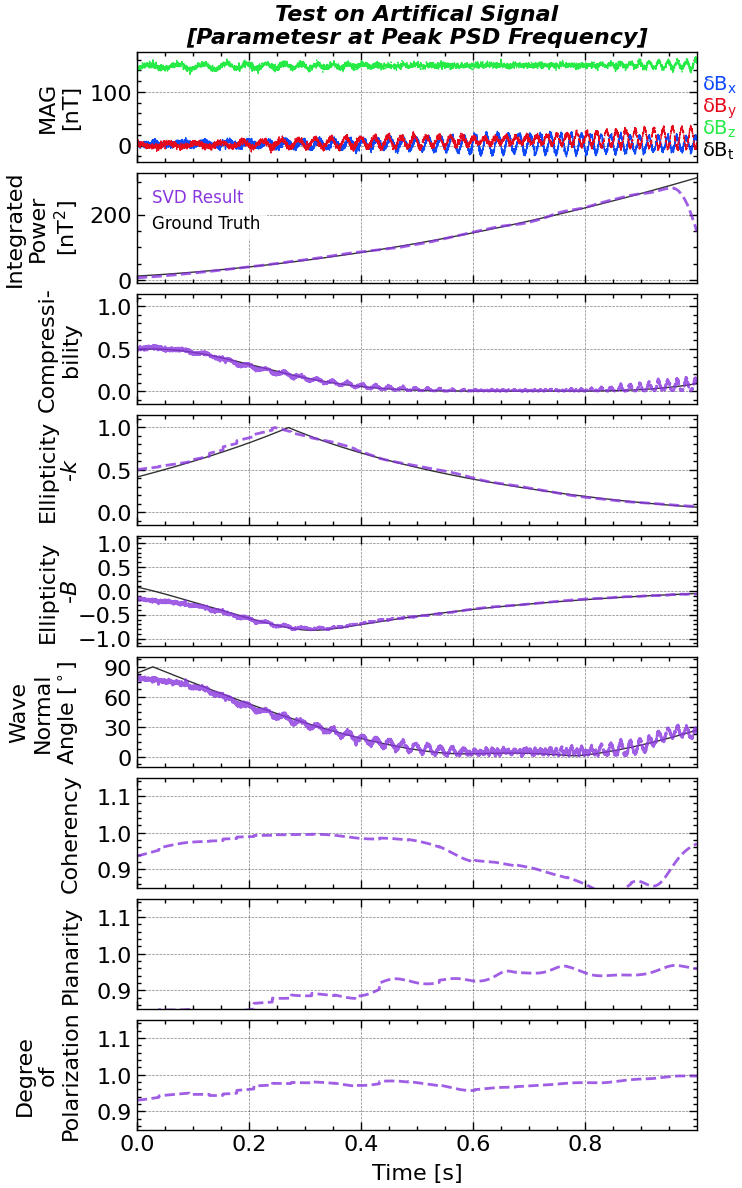

In [5]:
cmap = 'jet'
from scipy.signal import butter, filtfilt
import pywt
import ssqueezepy
import matplotlib.dates as mdate

np.random.seed(88888)

# ==== 时间参数 ====
N = 2 ** 12
t = np.linspace(0, 1, N, endpoint = False)

dt = t[1] - t[0]
fs = 1 / dt
# ==== Background Magnetic Field ====
theta_b = 0.5 * np.pi * np.sin(2 * np.pi * 0.02 * t)
phi_b = 0.5 * np.pi * np.cos(2 * np.pi * 0.01 * t)
strength_b = 150 + 30 * np.sin(2 * np.pi * 0.3 * t)

theta_b = 0.5 * np.pi * np.sin(2 * np.pi * 0.01 * t)
phi_b = 0.5 * np.pi * np.cos(2 * np.pi * 0.01 * t)
strength_b = 150 + 30 * np.sin(2 * np.pi * 0.02 * t)

bx = strength_b * np.sin(theta_b) * np.cos(phi_b)
by = strength_b * np.sin(theta_b) * np.sin(phi_b)
bz = strength_b * np.cos(theta_b)
b0 = np.stack([bx, by, bz], axis=1)  # T

# ==== Wave Magnetic Field ====
omega = 100 + 300 * np.sin(2 * np.pi * 0.2 * t)
delta_phase = np.pi / 2 * (0.5 + 1.5 * np.sin(2 * np.pi * 0.2 * t))
amp = np.linspace(5, 25, N)

# ==== Direction of Propagation ====
theta1 = 0.5 * np.pi * (1 + np.cos(2 * np.pi * 0.4 * t + 1.5))
phi1 = 0.4 * np.pi * (2 + np.sin(2 * np.pi * 0.6 * t + 0.8))

dirb = b0 / np.linalg.norm(b0, axis = 1)[:, None]

dir1 = np.stack([
    np.sin(theta1) * np.cos(phi1),
    np.sin(theta1) * np.sin(phi1),
    np.cos(theta1)
], axis=1)

dir2 = np.cross(dir1, np.array([0, 0, 1]))  # 垂直于 dir1 的方向
dir3 = np.cross(dir1, dir2)  # 垂直于 dir1 和 dir2 的方向

dir2 /= np.linalg.norm(dir2, axis=1)[:, None]
dir3 /= np.linalg.norm(dir3, axis=1)[:, None]

phase = np.cumsum(omega * dt)

sig_b_dir = (np.sin(phase)[:, None] * dir2 + np.sin(phase + delta_phase)[:, None] * dir3)
sig_b = amp[:, None] * sig_b_dir  # nT

sig_b = amp[:, None] * (np.exp(1j * phase)[:, None] * dir2 + np.exp(1j * (phase + delta_phase))[:, None] * dir3)
sig_b_dir = (np.sin(phase)[:, None] * dir2 + np.sin(phase + delta_phase)[:, None] * dir3)

sig_b_dir = (np.exp(1j * phase)[:, None] * dir2 + np.exp(1j * (phase + delta_phase))[:, None] * dir3)
sig_b_dir /= np.linalg.norm(sig_b_dir, axis = 1)[:, None]
sig_b = amp[:, None] * sig_b_dir

v_phase = 300e3  # m/s
sig_e = v_phase * np.cross(dir1, sig_b)  # V/m


real_wna = np.arccos(np.abs(np.sum(dir1 * dirb, axis=1)))  # 波动方向与背景磁场的夹角
# real_compressibility = np.abs(np.sum(sig_b_dir * b0 / np.linalg.norm(sig_b_dir, axis = 1)[:, None] / np.linalg.norm(b0, axis = 1)[:, None], axis=1)) ** 2  # 压缩率
# real_compressibility = np.sum(dir2 * b0 / np.linalg.norm(b0, axis = 1)[:, None], axis=1) ** 2 + np.sum(dir3 * b0 / np.linalg.norm(b0, axis = 1)[:, None], axis=1) ** 2  # 压缩率

real_compressibility = ( np.sum(dir2 * dirb, axis=1) ** 2 + np.sum(dir3 * dirb, axis=1) ** 2  \
    + 2 * np.cos(delta_phase) * np.sum(dir2 * dirb, axis=1) * np.sum(dir3 * dirb, axis=1) ) / 2 # 压缩率

real_ellipticity_along_k = np.exp(-np.abs(np.log(np.abs(np.tan(delta_phase / 2))))) # 波动方向与背景磁场的夹角


dir2_perp = np.cross(dir3, dirb)  # 垂直于 dir1 的方向
dir3_perp = np.cross(dirb, dir2_perp)  # 垂直于 dir1 和 dir2 的方向

# dir2_perp = dir2 - np.sum(dir2 * dirb, axis=1)[:, None] * dirb  # 垂直于 dir2 的方向
# dir3_perp = dir3 - np.sum(dir3 * dirb, axis=1)[:, None] * dirb  # 垂直于 dir1 的方向

# ratio = np.linalg.norm(dir3_perp, axis=1) / np.linalg.norm(dir2_perp, axis=1)

dir2_perp /= np.linalg.norm(dir2_perp, axis=1)[:, None]
dir3_perp /= np.linalg.norm(dir3_perp, axis=1)[:, None]

epara2_to_epara3_ratio = np.linalg.norm(np.cross(dir2, dirb), axis = 1) / np.linalg.norm(np.cross(dir3, dirb), axis = 1)  # epara1 与 epara2 的比值

real_ellipticity_along_b = np.tan( 1 / 2 * np.arcsin(2 * epara2_to_epara3_ratio * np.sin(delta_phase) / (1 + epara2_to_epara3_ratio ** 2 ) ) )  # 波动方向与背景磁场的夹角

amp2_perp = np.sum(sig_b * dir2_perp, axis = 1)
amp3_perp = np.sum(sig_b * dir3_perp, axis = 1)

amp_ratio_b = np.abs(amp2_perp) / np.abs(amp3_perp)
delta_phase_b = np.angle(amp2_perp) - np.angle(amp3_perp)

real_ellipticity_along_b = np.tan( 1 / 2 * np.arcsin(2 * amp_ratio_b * np.sin(delta_phase_b) / (1 + amp_ratio_b ** 2 ) ) )  # 波动方向与背景磁场的夹角

sig_poynting = np.cross(sig_e, sig_b.conj())  # V/m * T = Wb / m^2
real_poynting_angle = np.arccos((np.sum(sig_poynting.real * b0 / np.linalg.norm(sig_poynting.real, axis = 1)[:, None] / np.linalg.norm(b0, axis = 1)[:, None], axis=1)))  # 波动方向与背景磁场的夹角

# ==== Red Noise ====
noise_level = 3.0
white_b = np.random.randn(N, 3) * noise_level
white_e = np.random.randn(N, 3) * noise_level * v_phase
b_r, a_r = butter(2, 0.05)
red_b = filtfilt(b_r, a_r, white_b, axis=0)  # nT
red_e = filtfilt(b_r, a_r, white_e, axis=0)  # nT

# ==== 合成总磁场 B 与电场 E ====
b = b0 + sig_b + white_b  # nT
e = sig_e + white_e               # mV/m


NANOSECOND_TO_SECOND = 1e9

# Generate Vector Signal
# sig_ut = np.copy(t * NANOSECOND_TO_SECOND).astype('datetime64[ns]')
sig_ut = np.copy(t)
sig_bx = b[:, 0].real
sig_by = b[:, 1].real
sig_bz = b[:, 2].real
sig_bt = np.sqrt(sig_bx ** 2 + sig_by ** 2 + sig_bz ** 2)

sig_ex = e[:, 0].real
sig_ey = e[:, 1].real
sig_ez = e[:, 2].real

%matplotlib ipympl

plt.close()

plt.figure(figsize=(8, 14))
plt.subplots_adjust(hspace = 0.1, right = 0.90, left = 0.2)
# matplotlib.rcParams['figure.dpi'] = 300

fig = plt.gcf()

ax1 = plt.subplot(9, 1, 1)
plot_line = True
ax2 = plt.subplot(9, 1, 2, sharex = ax1)

if plot_line:
    sharey = None
else:
    sharey = ax2

ax3 = plt.subplot(9, 1, 3, sharex = ax1, sharey = sharey)
ax4 = plt.subplot(9, 1, 4, sharex = ax1, sharey = sharey)
ax5 = plt.subplot(9, 1, 5, sharex = ax1, sharey = sharey)
ax6 = plt.subplot(9, 1, 6, sharex = ax1, sharey = sharey)
ax7 = plt.subplot(9, 1, 7, sharex = ax1, sharey = sharey)
ax8 = plt.subplot(9, 1, 8, sharex = ax1, sharey = sharey)
ax9 = plt.subplot(9, 1, 9, sharex = ax1, sharey = sharey)

use_wavelet = True

if use_wavelet:
    bandwidth = 12.0
    # log-scale
    scales = np.power(2, np.linspace(3, 9, 6 * 12 + 1))
    # linear-scale (for comparing with the windowed FFT)
    # scales = np.arange(2, 400)
    downsample = 1 # For comparing with the windowed FFT with a step of 50
    freq_window = 3
    time_window = 9
    downsample_signal = False # Downsample the signal before computing wavelet coefficients (True) or Downsample the coefficients after computing (False)

    t, freq, coef_bx, psd_bx, avg_bx = wavelet_coef_psd(sig_ut, sig_bx, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_by, psd_by, avg_by = wavelet_coef_psd(sig_ut, sig_by, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_bz, psd_bz, avg_bz = wavelet_coef_psd(sig_ut, sig_bz, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_bt, psd_bt, avg_bt = wavelet_coef_psd(sig_ut, sig_bt, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)

    _, _, coef_ex, psd_ex, avg_ex = wavelet_coef_psd(sig_ut, sig_ex, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_ey, psd_ey, avg_ey = wavelet_coef_psd(sig_ut, sig_ey, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_ez, psd_ez, avg_ez = wavelet_coef_psd(sig_ut, sig_ez, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)

    coi = (np.sqrt(2) * bandwidth / (2 * np.pi) / freq).astype(float)


    mu = bandwidth
    scale_to_period = 4 * np.pi / (mu + np.sqrt(2 + mu ** 2)) / fs

    period = scale_to_period * scales

    # where wavelet coeficients damp to e^-2
    coi = np.sqrt(2) * scales * scale_to_period

    if isinstance(sig_ut[0], np.datetime64):
        coi = (1e9 * coi).astype('timedelta64[ns]')

else:

    freq_window = 2
    time_window = 2
    
    step = 2 ** 3
    window = 2 ** 9

    t, freq, coef_bx, psd_bx, avg_bx = wfft_coef_psd(sig_ut, sig_bx, step = step, window = window)
    _, _, coef_by, psd_by, avg_by = wfft_coef_psd(sig_ut, sig_by, step = step, window = window)
    _, _, coef_bz, psd_bz, avg_bz = wfft_coef_psd(sig_ut, sig_bz, step = step, window = window)
    _, _, coef_bt, psd_bt, _ = wfft_coef_psd(sig_ut, sig_bt, step = step, window = window)

    _, _, coef_ex, psd_ex, avg_ex = wfft_coef_psd(sig_ut, sig_ex, step = step, window = window)
    _, _, coef_ey, psd_ey, avg_ey = wfft_coef_psd(sig_ut, sig_ey, step = step, window = window)
    _, _, coef_ez, psd_ez, avg_ez = wfft_coef_psd(sig_ut, sig_ez, step = step, window = window)

    downsample = 1

psd_b = (psd_bx + psd_by + psd_bz)
psd_e = (psd_ex + psd_ey + psd_ez)

# df = freq * (freq[0] / freq[1] - freq[1] / freq[0])
std_b = np.sqrt(np.std(sig_bx) ** 2 + np.std(sig_by) ** 2 + np.std(sig_bz) ** 2)

psd_threshold = scipy.stats.chi2(2).ppf(.95) / 2 * (std_b ** 2) * dt
# psd_threshold *= 0.0

coef = np.array([coef_bx, coef_by, coef_bz]).transpose(1, 2, 0)
spec = np.einsum('fti,ftj->ftij', coef, coef.conj())

spec_smooth = smooth_spec_gaussian(spec, scales, axis = 0, a = 1.0)
spec_smooth = smooth_spec_box(spec_smooth, scales, 0.6, axis = 0)

# spec_smooth = bn.move_mean(spec_smooth, window=freq_window, min_count=1, axis=0)
# spec_smooth = bn.move_mean(spec_smooth, window=time_window, min_count=1, axis=1)

avg = np.array([avg_bx, avg_by, avg_bz]).T
magf_direction = ((avg.T) / np.linalg.norm(avg, axis = 1)).T

planarity, ellipticity_along_k, coherence, degree_of_polarization, vh = svd_wave_analysis(spec_smooth, freq_window = freq_window, time_window = time_window)
compressibility, ellipticity_along_b = fac_wave_analysis(spec_smooth, magf_direction)
wave_normal_angle = np.rad2deg(np.arccos(np.abs(np.sum(magf_direction * vh[:, :, 2, :], axis = -1))))
poynting_matrix = np.cross(np.array([coef_ex, coef_ey, coef_ez]).transpose(1, 2, 0), np.conj(np.array([coef_bx, coef_by, coef_bz])).transpose(1, 2, 0), axis = -1)
poynting_angle = np.rad2deg(np.arccos((np.sum(magf_direction * ((poynting_matrix.real.T) / np.linalg.norm(poynting_matrix.real.T, axis = 0)).T, axis = -1))))

_mask_idx = np.where(psd_b < psd_threshold)
compressibility[_mask_idx] = np.nan
ellipticity_along_k[_mask_idx] = np.nan
ellipticity_along_b[_mask_idx] = np.nan
wave_normal_angle[_mask_idx] = np.nan
poynting_angle[_mask_idx] = np.nan
coherence[_mask_idx] = np.nan
planarity[_mask_idx] = np.nan
degree_of_polarization[_mask_idx] = np.nan

ax1.plot(sig_ut, sig_bx + 3, 'C0', lw = 1)
ax1.plot(sig_ut, sig_by, 'C1', lw = 1)
ax1.plot(sig_ut, sig_bz - 3, 'C2', lw = 1)

# pc2 = ax2.pcolormesh(time, frequency, np.log10(psd_b * (1 - degree_of_polarization)), cmap=cmap, shading='auto', vmax = 5.0, vmin = -1.0, rasterized = True)
# pc3 = ax3.pcolormesh(t, freq, np.log10(psd_e), cmap=cmap, shading='auto', vmax = 12.0, vmin = 6.0, rasterized = True)

_freq_idx_max_psd_b = np.argmax(psd_b[:], axis = 0)

if plot_line:
    line_dict = {
        'linestyle': '--',
        'linewidth' : 2.0,
        'alpha': 0.8,
        'color': 'C3',
        'label': 'SVD Result'
        }

    psd_b[_mask_idx] = np.nan

    # ax2.plot(t, psd_b[(_freq_idx_max_psd_b, np.arange(len(_freq_idx_max_psd_b)))], **line_dict)
    ax2.plot(t, np.nansum((psd_b * freq[:, None] * (np.sqrt(freq[0] / freq[1]) - np.sqrt(freq[1] / freq[0]))), axis = 0), **line_dict)
    ax3.plot(t, compressibility[(_freq_idx_max_psd_b, np.arange(len(_freq_idx_max_psd_b)))], **line_dict)
    ax4.plot(t, ellipticity_along_k[(_freq_idx_max_psd_b, np.arange(len(_freq_idx_max_psd_b)))], **line_dict)
    ax5.plot(t, ellipticity_along_b[(_freq_idx_max_psd_b, np.arange(len(_freq_idx_max_psd_b)))], **line_dict)
    ax6.plot(t, wave_normal_angle[(_freq_idx_max_psd_b, np.arange(len(_freq_idx_max_psd_b)))], **line_dict)
    ax7.plot(t, coherence[(_freq_idx_max_psd_b, np.arange(len(_freq_idx_max_psd_b)))], **line_dict)
    ax8.plot(t, planarity[(_freq_idx_max_psd_b, np.arange(len(_freq_idx_max_psd_b)))], **line_dict)
    ax9.plot(t, degree_of_polarization[(_freq_idx_max_psd_b, np.arange(len(_freq_idx_max_psd_b)))], **line_dict)


    line_dict = {
        'linestyle': '-',
        'linewidth' : 1.0,
        'alpha': 0.8,
        'color': 'k',
        'zorder': -1,
        'label': 'Ground Truth',
        'path_effects' : [pe.withStroke(linewidth=0.0, foreground="w")]
    }

    ax2.plot(sig_ut, (0.5 * amp ** 2) * N * dt, **line_dict)
    ax3.plot(sig_ut, real_compressibility, **line_dict)
    ax4.plot(sig_ut, real_ellipticity_along_k[::], **line_dict)
    ax5.plot(sig_ut, real_ellipticity_along_b[::], **line_dict)
    ax6.plot(sig_ut, np.rad2deg(real_wna)[::], **line_dict)

    ax3.set_ylim(-.15, 1.15)
    ax4.set_ylim(-.15, 1.15)
    ax5.set_ylim(-1.15, 1.15)
    ax6.set_ylim(-10, 100.0)
    ax7.set_ylim(.85, 1.15)
    ax8.set_ylim(.85, 1.15)
    ax9.set_ylim(.85, 1.15)

    ax3.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax4.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax5.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax6.yaxis.set_major_locator(ticker.MultipleLocator(30))
    ax7.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax8.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax9.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    
    ax2.set_ylabel('Integrated\nPower\n' + r'[$\mathrm{nT^2}$]')
    ax3.set_ylabel('Compressi-\nbility')
    ax4.set_ylabel('Ellipticity\n' + r'-$k$')
    ax5.set_ylabel('Ellipticity\n' + r'-$B$')
    ax6.set_ylabel('Wave\nNormal\nAngle [$^\circ$]')
    ax7.set_ylabel('Coherency')
    ax8.set_ylabel('Planarity')
    ax9.set_ylabel('Degree\nof\nPolarization')
    ax2.legend(ncol = 1, labelcolor="linecolor", handlelength = 0, handletextpad = 0, prop = {'weight': 'normal', 'size' : 12})

else:
    pc2 = ax2.pcolormesh(t, freq, np.log10(psd_b), cmap=cmap, shading='auto', vmax = 1.0, vmin = -3.0, rasterized = True, zorder = -1)
    ax2.contour(t, freq, psd_b, levels = [psd_threshold], colors = 'k', linewidths = 1.5, linestyles = 'solid')
    ax2.plot(t, freq[_freq_idx_max_psd_b], 'w--', lw = 1.0, path_effects = [pe.withStroke(linewidth=2.0, foreground="k")])
    pc3 = ax3.pcolormesh(t, freq, compressibility, cmap=cmap, vmax = 1.0, vmin = 0, rasterized = True, zorder = -1)
    pc4 = ax4.pcolormesh(t, freq, ellipticity_along_k, cmap=cmap, vmax = 1.0, vmin = 0.0, rasterized = True, zorder = -1)
    pc5 = ax5.pcolormesh(t, freq, ellipticity_along_b, cmap=cmap, vmax = 1.0, vmin = -1.0, rasterized = True, zorder = -1)
    pc6 = ax6.pcolormesh(t, freq, wave_normal_angle, cmap = 'bwr', vmax = 90.0, vmin = 0, rasterized = True, zorder = -1)
    # pc8 = ax8.pcolormesh(t, freq, poynting_angle, cmap='bwr', vmax = 180.0, vmin = 0, rasterized = True)
    pc7 = ax7.pcolormesh(t, freq, coherence, cmap=cmap, vmax = 1.0, vmin = 0.8, rasterized = True, zorder = -1)
    pc8 = ax8.pcolormesh(t, freq, planarity, cmap=cmap, vmax = 1.0, vmin = 0.8, rasterized = True, zorder = -1)
    pc9 = ax9.pcolormesh(t, freq, degree_of_polarization, cmap=cmap, vmax = 1.0, vmin = 0.8, rasterized = True, zorder = -1)

    text_dict = {
        'fontsize': 14,
        'alpha': 1.0,
        'color': 'k',
        'path_effects': [pe.withStroke(linewidth=1.5, foreground="w")],
        'bbox' : dict(facecolor='#888888', alpha=0.0, edgecolor='none', pad=0),
        'ha': 'left',
        'va': 'top',
    }

    plt.text(0.02, 0.9, r'$\mathrm{log_{10}(PSD)}$ [$\mathrm{nT^2/Hz}$]', transform=ax2.transAxes, **text_dict)
    plt.text(0.02, 0.9, r'Compressibility', transform=ax3.transAxes, **text_dict)
    plt.text(0.02, 0.9, r'Ellipticity Along $k$', transform=ax4.transAxes, **text_dict)
    plt.text(0.02, 0.9, r'Ellipticity Along $B$', transform=ax5.transAxes, **text_dict)
    plt.text(0.02, 0.9, r'Wave Normal Angle [$^\circ$]', transform=ax6.transAxes, **text_dict)
    plt.text(0.02, 0.9, r'Coherency', transform=ax7.transAxes, **text_dict)
    plt.text(0.02, 0.9, r'Planarity', transform=ax8.transAxes, **text_dict)
    plt.text(0.02, 0.9, r'Degree of Polarization', transform=ax9.transAxes, **text_dict)

    pcs = [None, pc2, pc3, pc4, pc5, pc6, pc7, pc8, pc9]
    cbars = [None, None, None, None, None, None, None, None, None, None, None]

    ax2.set_yscale('log')
    ax2.set_ylim(np.nanmin(freq[freq > 0]), np.nanmax(freq))

    for i, ax in enumerate(plt.gcf().axes):

        if ax != ax1:
            ax.set_facecolor('#888888')

            if use_wavelet:
                ax.fill_betweenx(freq, x1 = t[0], x2 = t[0] + coi, alpha = 0.6, color = '#CCCCCC', hatch = None)
                ax.fill_betweenx(freq, x1 = t[-1], x2 = t[-1] - coi, alpha = 0.6, color = '#CCCCCC', hatch = None)

            ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs = (1,)))
            ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='all'))
            
            cbar_ax = fig.add_axes(
                [ax.get_position().x1 + 0.01, ax.get_position().y0 + 0.005, 0.03, ax.get_position().y1 - ax.get_position().y0 - 0.01])
            cbars[i] = fig.colorbar(pcs[i], cax=cbar_ax)
            cbars[i].ax.tick_params(which='major', length=4, direction='in', pad=3)
            cbars[i].set_ticks([cbars[i].vmin, (cbars[i].vmax + cbars[i].vmin) / 2, cbars[i].vmax])
            ax.yaxis.set_major_locator(ticker.AutoLocator())
            ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
            # if i % 3 == 2:
            ax.set_ylabel('Frequency\n[Hz]')
            ax.yaxis.set_major_locator(ticker.LogLocator(base = 10))
            ax.yaxis.set_minor_locator(ticker.LogLocator(base = 10, subs = 'all', numticks = 10))
            

ax1.grid('on')
# ax2.set_ylim(450, 2450)
# ax2.set_yscale('log')
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.set_ylabel('MAG\n[nT]')

for i, ax in enumerate(plt.gcf().axes):
    # ax.xaxis.set_major_formatter(mdate.ConciseDateFormatter(ax.xaxis.get_major_locator(),offset_formats=['', '%Y', '%Y-%b', '%Y-%b-%d', '%Y-%b-%d', '%Y-%b-%d']))
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_label_coords(-0.10, 0.5)
    if ax != ax9:
        plt.setp(ax.get_xticklabels(), visible=False)

    # if i % 2 == 1:
    #     ax.yaxis.tick_right()
    #     ax.yaxis.set_label_position("right")


ax1.set_xlim(sig_ut[0], sig_ut[-1])
# plt.text(0.02, 0.9, r'$\mathbf{(A)}$', transform=ax1.transAxes, **text_dict)

plt.text(1.01, 0.80, r'$\mathrm{\delta B_x}$', ha = 'left', va='top', transform=ax1.transAxes, color = 'C0', fontsize = 14)
plt.text(1.01, 0.60, r'$\mathrm{\delta B_y}$', ha='left', va='top', transform=ax1.transAxes, color = 'C1', fontsize = 14)
plt.text(1.01, 0.40, r'$\mathrm{\delta B_z}$', ha='left', va='top', transform=ax1.transAxes, color = 'C2', fontsize = 14)
plt.text(1.01, 0.20, r'$\mathrm{\delta B_t}$', ha='left', va='top', transform=ax1.transAxes, color = 'k', fontsize = 14)

ax9.set_xlabel('Time [s]')


_title = 'Test on Artifical Signal\n'
_title = _title + ('[Parametesr at Peak PSD Frequency]' if plot_line else '[Time-Frequency Spectra]')
ax1.set_title(_title , **title_font)
# plt.tight_layout()

# plt.savefig(save_path + 'figure_svd_' + ('line' if plot_line else 'spectra') + '.png',bbox_inches='tight',dpi=300)

plt.show()